In [91]:
import os.path as os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, PointNetConv, fps, global_max_pool, radius
from torch_geometric.typing import WITH_TORCH_CLUSTER

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [92]:
# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

B = 1 

# load dataset
dataset = du.SDFDataset("./cars100")
train_percent = 0.8

# split dataset into training and validation sets
train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 80, Validation dataset size: 20


In [93]:
def process_batch(batch, np_in=2048, np_q=15000):
    B, N, _ = batch.shape
    assert B == 1, "Batch size must be 1 for now."
    
    # # use surface points
    # surface_points = batch[batch[:, :, 3] == 0]
    idx = torch.randperm(N)[:np_in]
    pos = batch[:, idx, :3] # input positions (B, N, 3) -> (N, 3) # this is what fps expects
    x = batch[0, idx, 3].unsqueeze(-1)
    
    idx = torch.randperm(N)[:np_q]
    query_pos = batch[:, idx, :3] # query positions
    query_sdf = batch[:, idx, 3] # SDF values
    
    batch_vec = torch.zeros(np_in, dtype=torch.long) # batch vector for input points
    
    return x.to(device), pos.contiguous().squeeze(0).to(device), batch_vec.contiguous().squeeze(0).to(device), query_pos.squeeze(0).to(device), query_sdf.squeeze(0).to(device)

Define Layers and Model

In [94]:
class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointNetConv(nn, add_self_loops=False)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=128)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch

class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([4, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.5, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.encode = MLP([1024, 512, 256], dropout=0.3, norm=None)
        self.sdf = MLP([256 + 3, 128, 64, 1], dropout=0.3, norm=None)

    def forward(self, x, pos, batch, query_pos):
        # encode shape
        sa0_out = (x, pos, batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        x, pos, batch = sa3_out
        
        encoded = self.encode(x)
        concated = torch.cat((encoded.squeeze(0).repeat(query_pos.shape[0], 1), query_pos), dim=-1) # concatenate encoded shape with query positions

        return self.sdf(concated)

In [95]:
# test model
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch = next(iter(train_loader))
print(f'Batch shape: {batch.shape}')
x, pos, batch, query_pos, query_sdf = process_batch(batch)
print(f'pos shape: {pos.shape}, query_pos shape: {query_pos.shape}, query_sdf shape: {query_sdf.shape}, x shape: {x.shape}')

print(f'pos shape: {pos.shape}')
# forward pass
output = model(x, pos, batch, query_pos)
# print output shape
print(f"Output shape: {output.shape}")

Batch shape: torch.Size([1, 50000, 4])
pos shape: torch.Size([2048, 3]), query_pos shape: torch.Size([15000, 3]), query_sdf shape: torch.Size([15000]), x shape: torch.Size([2048, 1])
pos shape: torch.Size([2048, 3])
Output shape: torch.Size([15000, 1])


MODEL


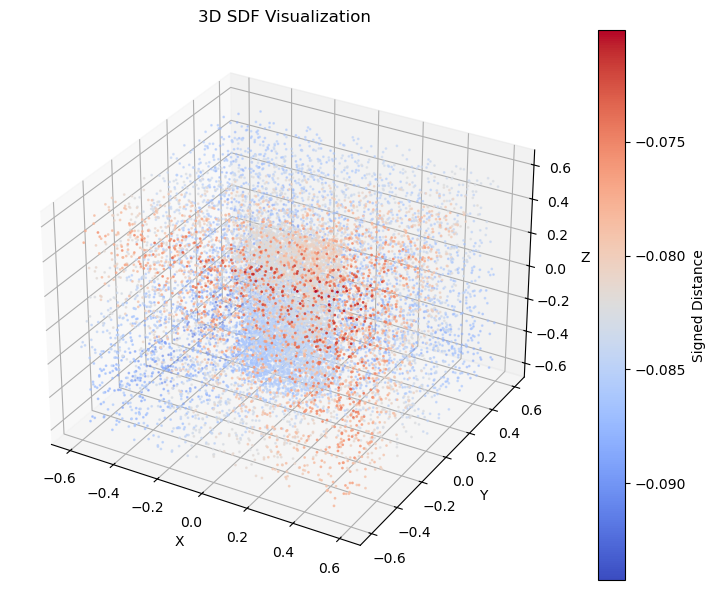

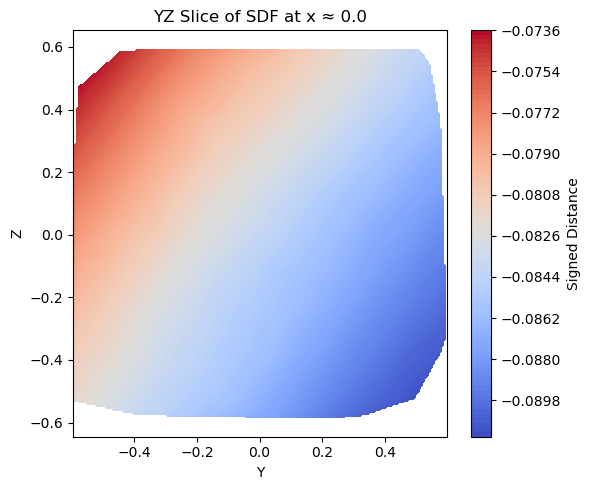

TRUTH


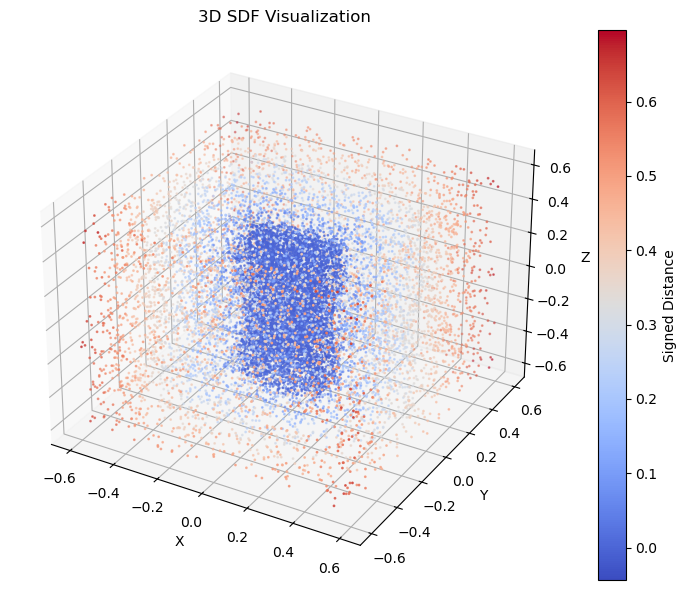

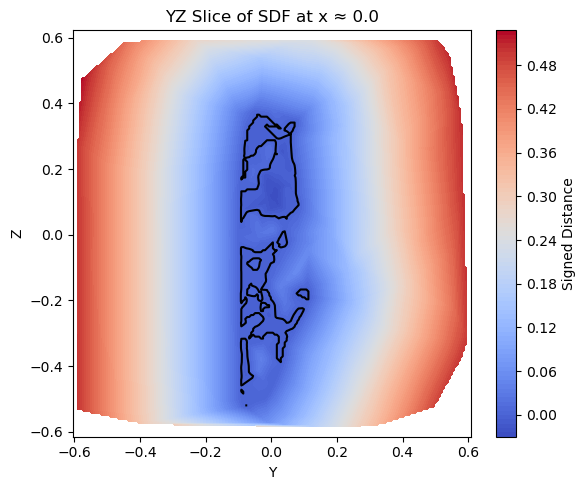

Validation Loss: 0.11471658200025558


In [96]:
def show_validation():
    model.eval()
    batch = next(iter(val_loader))
    x, pos, batch, query_pos, query_sdf = process_batch(batch)
    output = model(x, pos, batch, query_pos)

    prediction = torch.cat((query_pos, output), dim=-1).detach().cpu()  # (1024, 3 + 1)
    truth = torch.cat((query_pos, query_sdf.unsqueeze(-1)), dim=-1).detach().cpu()  # (1024, 3 + 1)

    print("MODEL")
    du.visualize_sdf_3d(prediction)
    du.visualize_sdf_2d(prediction)
    print("TRUTH")
    du.visualize_sdf_3d(truth)
    du.visualize_sdf_2d(truth)

    loss = F.mse_loss(output.squeeze(-1), query_sdf)  # L1 loss for SDF prediction
    print("Validation Loss:", loss.item())

show_validation()

In [97]:
def eikonal_loss(out, query_pos):
    grads = torch.autograd.grad(out.sum(), query_pos, create_graph=True)[0]
    loss = ((grads.norm(2, dim=1) - 1).square()).mean()
    return loss

def compute_loss(out, query_pos, query_sdf, const=0.01):
    loss_mse = F.mse_loss(out, query_sdf)
    loss_eik = eikonal_loss(out, query_pos)

    total_loss = loss_mse + const * loss_eik
    
    return total_loss


 20%|██        | 2/10 [01:30<06:03, 45.38s/it]

Loss: 0.0507


 40%|████      | 4/10 [02:58<04:26, 44.48s/it]

Loss: 0.0169


 60%|██████    | 6/10 [04:25<02:55, 43.82s/it]

Loss: 0.0079


 80%|████████  | 8/10 [05:54<01:28, 44.10s/it]

Loss: 0.0054


 90%|█████████ | 9/10 [06:38<00:44, 44.01s/it]

Loss: 0.0052
MODEL


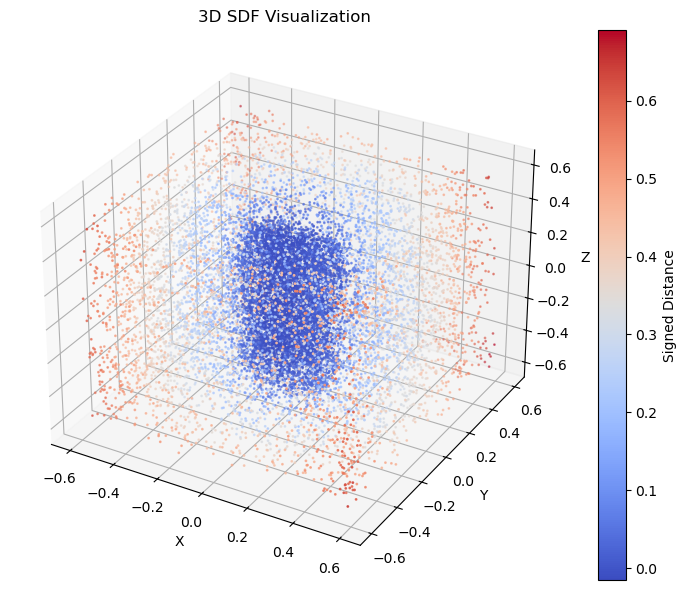

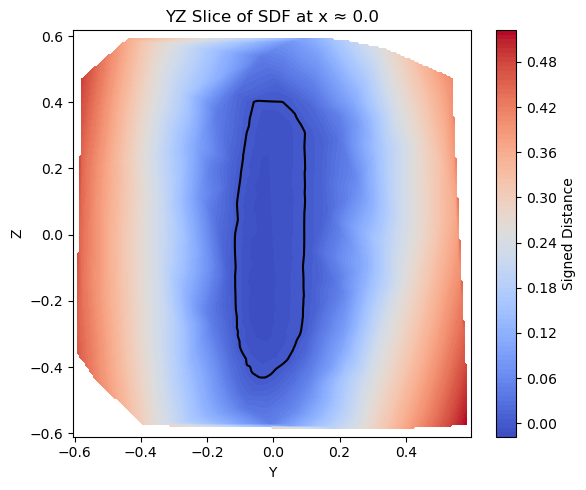

TRUTH


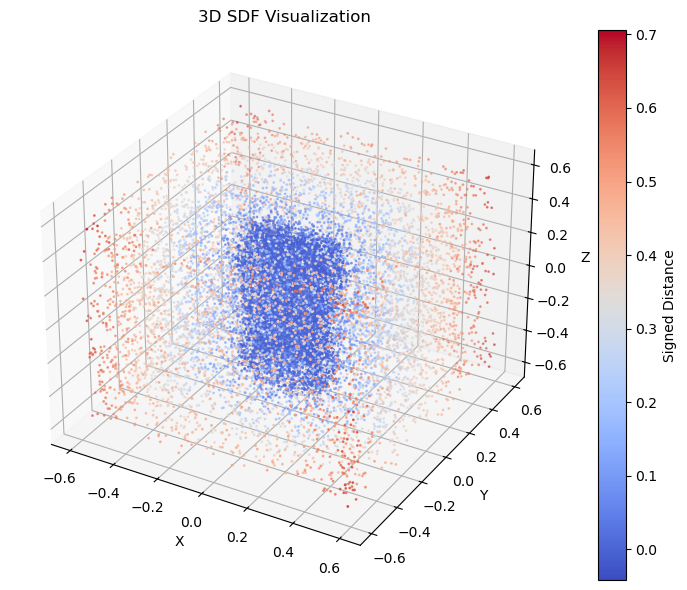

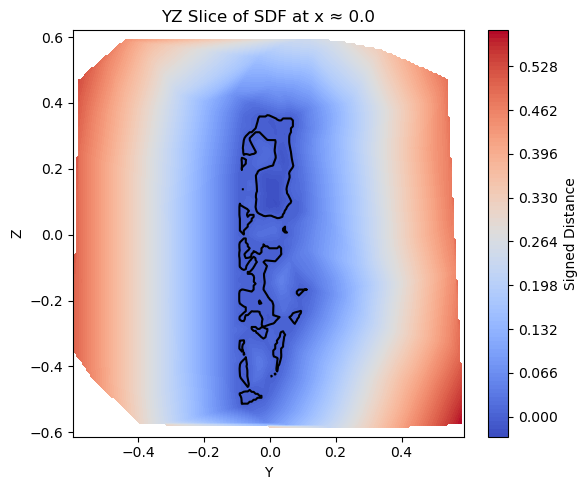

100%|██████████| 10/10 [07:35<00:00, 45.57s/it]

Validation Loss: 0.0008309951517730951


In [98]:
from tqdm import tqdm

EPOCHS = 10

def train():
    model.train()
    for batch in train_loader:
        x, pos, batch, query_pos, query_sdf = process_batch(batch)
        query_pos.requires_grad = True

        optimizer.zero_grad()
        out = model(x, pos, batch, query_pos).squeeze(-1)
        loss = compute_loss(out, query_pos, query_sdf)

        loss.backward()
        optimizer.step()
    
    return loss.item()

for epoch in tqdm(range(1, EPOCHS + 1)):
    loss = train()

    if epoch % 2 == 0:
        print('Loss: {:.4f}'.format(loss))

    if epoch % 10 == 0:
        show_validation()
        # save model
        torch.save(model.state_dict(), 'pointnet_sdf.pth')